In [1]:
import pyro
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO, Predictive, TraceEnum_ELBO
from pyro.optim import ClippedAdam
from torch.utils.data import TensorDataset, DataLoader


from pyro_mixture_model import MixtureModel, MixtureModelGuide
from Preprocess_data import create_summed_df
from utils import split_patient_level, summarize_columns, save_model_and_losses
# set random seed for reproducibility
np.random.seed(42)

experiment_name = "testing"
save_dir = os.path.join("outputs", experiment_name)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

c:\Users\marie\miniconda3\envs\mbml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data and prepare it

In [2]:
if not os.path.exists("data/CaseRigshospitalet_summed.parquet"):
    print("Creating data file")
    create_summed_df()
print("Loading data file")
df = pd.read_parquet("data/CaseRigshospitalet_summed.parquet")

print("Number of data points ", len(df))
print("Number of patients ", len(df["Patient ID"].unique()))
summarize_columns(df)

Loading data file
Number of data points  497198
Number of patients  331647
                           name     dtype  unique  size (MB)
0                    Patient ID  category  331647         30
1           Aktionsdiagnosekode  category    8167          1
2  totalDiagnoseKontaktVarighed   float32    8160          1
3                antalKontakter     int64     141          3
4                antalDiagnoser     int64      17          3
5                         alder   Float64   14014          4
6                        gender  category       4          0
7                    civilStand  category       4          0
8          distanceToHospitalKM   float64    1772          3
Total size (excluding "embedding"): 50.595398902893066 MB


### Create train and test data split

In [3]:
total_samples=100000
(x_emb_train, d_demo_train, v_time_train, c_count_train), (x_emb_test, d_demo_test, v_time_test, c_count_test) = split_patient_level(df, total_samples=total_samples)

Demographic columns: ['alder', 'distanceToHospitalKM', 'gender_Kvinde', 'gender_Mand', 'gender_Ukendt', 'civilStand_Fraskilt', 'civilStand_Gift', 'civilStand_Ugift']


### Investigate data

In [4]:
# mean of train v_time
mean_v_time = torch.mean(v_time_train)
print(f"Mean v_time: {mean_v_time}")
print("Minimum v_time: ", torch.min(v_time_train))
print("Maximum v_time: ", torch.max(v_time_train))

c_count_train = c_count_train.to(torch.float32)
mean_a_count = torch.mean(c_count_train).log()
print(f"Mean a_count: {mean_a_count}")
print("Minimum a_count: ", torch.min(c_count_train))
print("Maximum a_count: ", torch.max(c_count_train))

# mean of test v_time
mean_v_time_test = torch.mean(v_time_test)
print(f"Mean v_time_test: {mean_v_time_test}")
print("Minimum v_time_test: ", torch.min(v_time_test))
print("Maximum v_time_test: ", torch.max(v_time_test))

Mean v_time: 4.124870777130127
Minimum v_time:  tensor(0.0200, dtype=torch.float32)
Maximum v_time:  tensor(509.0700, dtype=torch.float32)
Mean a_count: 1.302257776260376
Minimum a_count:  tensor(1., dtype=torch.float32)
Maximum a_count:  tensor(204., dtype=torch.float32)
Mean v_time_test: 4.06215763092041
Minimum v_time_test:  tensor(0.0200, dtype=torch.float32)
Maximum v_time_test:  tensor(333.2400, dtype=torch.float32)


### Preprocess data
First, we perform a pca to diminish the dimensions of the bert embeddings of the text, $x$.

In [5]:
# PCA on x_emb_train
from sklearn.decomposition import PCA
# Fit PCA and choose number of components by covering 95% of variance
pca = PCA(n_components=0.95)
pca.fit(x_emb_train.numpy())
print(f"Number of PCA components: {pca.n_components_}")
# Transform the data
x_emb_train_pca = torch.tensor(pca.transform(x_emb_train.numpy()), dtype=torch.float32)
x_emb_test_pca = torch.tensor(pca.transform(x_emb_test.numpy()), dtype=torch.float32)
print("Shape of x_emb_train: ", x_emb_train.shape)
print("Shape of x_emb_train_pca: ", x_emb_train_pca.shape)

Number of PCA components: 150
Shape of x_emb_train:  torch.Size([79917, 768])
Shape of x_emb_train_pca:  torch.Size([79917, 150])


Then we standardize the input $x$ and $d$. The output visitation time, $v$, is log transformed (to allow use of a normal function to estimate) and then standardized. The output visit count is not standardized as it does not make sense for count data.

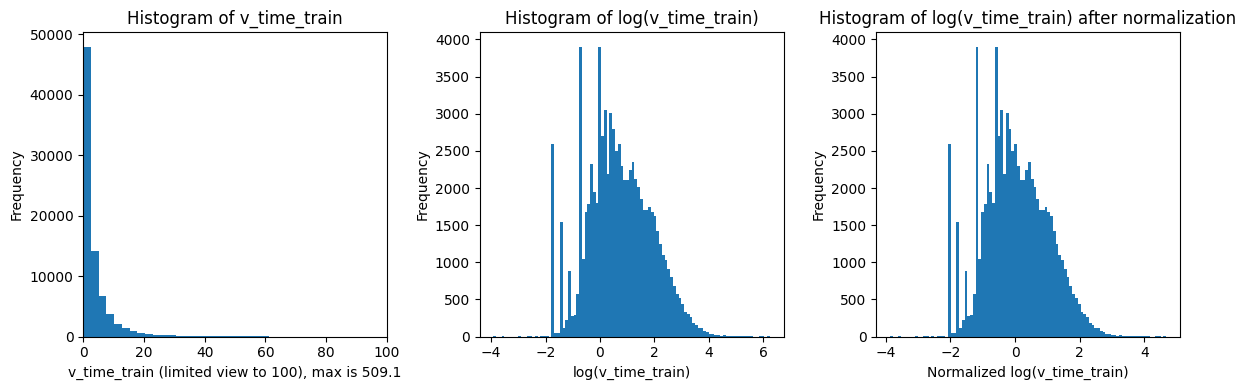

In [6]:
def standardize_tensor(tensor, mean=None, std=None):
    if mean is None or std is None:
        # Calculate mean and std if not provided
        mean = torch.mean(tensor)
        std = torch.std(tensor)
    return (tensor - mean) / std, mean, std

def reverse_standardize_tensor(tensor, mean, std):
    return tensor * std + mean

# Standardize the tensors
x_emb_train, mean, std = standardize_tensor(x_emb_train)
x_emb_test, _, _ = standardize_tensor(x_emb_test, mean, std)

x_emb_train_pca, mean, std = standardize_tensor(x_emb_train_pca)
x_emb_test_pca, _, _ = standardize_tensor(x_emb_test_pca, mean, std)

# normalize the first and last elements of d_demo_train and d_demo_test aka age and distance
d_demo_train[:,0], mean, std = standardize_tensor(d_demo_train[:,0])
d_demo_test[:,0], _, _ = standardize_tensor(d_demo_test[:,0], mean, std)
d_demo_train[:,-1], mean, std = standardize_tensor(d_demo_train[:,-1])
d_demo_test[:,-1], _, _ = standardize_tensor(d_demo_test[:,-1], mean, std)

fig, ax = plt.subplots(1,3, figsize=(12, 4))
ax[0].hist(v_time_train, bins=200)
ax[0].set_title("Histogram of v_time_train")
ax[0].set_xlabel(f"v_time_train (limited view to 100), max is {torch.max(v_time_train):.1f}")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(0, 100)

v_time_train_log = torch.log(v_time_train)
#plot histogram of v_time_train_log
ax[1].hist(v_time_train_log.cpu().numpy(), bins=100)
ax[1].set_title("Histogram of log(v_time_train)")
ax[1].set_xlabel("log(v_time_train)")
ax[1].set_ylabel("Frequency")


v_time_train_log, v_time_mean, v_time_std = standardize_tensor(v_time_train_log)
ax[2].hist(v_time_train_log.cpu().numpy(), bins=100)
ax[2].set_title("Histogram of log(v_time_train) after normalization")
ax[2].set_xlabel("Normalized log(v_time_train)")
ax[2].set_ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "v_time_histograms.pdf"))
plt.show()

v_time_test_log = torch.log(v_time_test)
v_time_test_log, _, _ = standardize_tensor(v_time_test, v_time_mean, v_time_std)


## Train

The generative process we are training is below. The $\beta_0$ and $\gamma_0$ are initialized with a prior with the empiric average. The $\lambda$ is clamped within $[\exp (-5.0), \exp (5.4)]$


**Generative Process:**

1) Draw $\theta \sim \text{Dirichlet}(\alpha)$

2) For each group, $g$, in $G$:

    2a) Draw $\beta_g \sim \mathcal{N}(0,\bm{I}_K)$

    2b) Draw $\gamma_g \sim \mathcal{N}(0,\bm{I}_K)$

    2c) Draw $\sigma_g \sim \text{HalfCauchy}(5)$

3) For each patient, $p$, in patients:

    3a) Draw group assignment $\bm{g}_p \sim \text{Categorical}(\theta)$

    3b) $\tilde{\mu} = \beta_{0}^g + \bm{\beta}_x^g \bm{x}_p + \bm{\beta}_d^g \bm{d}_p$
    
    3c) $\tilde{\lambda} = \exp (\gamma_{0}^g + \bm{\gamma}_x^g \bm{x}_p + \bm{\gamma}_d^g \bm{d}_p)$
    
    3d) Draw $\bm{v}_p \sim \text{LogNormal}(\tilde{\mu}, \sigma_{g_p})$ 
    
    3e) Draw $\bm{c}_p \sim \text{Poisson}(\tilde{\lambda})$ 

In [7]:
pyro.set_rng_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.set_default_device(device)
torch.set_default_dtype(torch.float64)

# create a CUDA-based RNG for DataLoader
cuda_gen = torch.Generator(device=device).manual_seed(42)

x_emb_train = x_emb_train.to(device)
x_emb_train_pca = x_emb_train_pca.to(device)
d_demo_train = d_demo_train.to(device)
v_time_train  = v_time_train.to(device)
c_count_train = c_count_train.to(device)
v_time_train_log = v_time_train_log.to(device)

R = len(x_emb_train)
batch_size = 2**11 #max is 2**17
dataset = TensorDataset(x_emb_train_pca, d_demo_train, v_time_train_log, c_count_train)
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=True, 
                        generator=cuda_gen, 
                        num_workers=4,
                        persistent_workers=True
                    )

G=10

# Setup SVI
optimizer = ClippedAdam({"lr": 1e-4})

svi = SVI(MixtureModel, MixtureModelGuide, optimizer, loss=TraceEnum_ELBO(max_plate_nesting=1))
losses = []
# Training loop
def train_batch(num_epochs=1000):
    #losses = []
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x_b, d_b, v_b, c_b in dataloader:
            total_loss += svi.step(x_b, d_b, v_b, c_b, G, device, batch_size=len(x_b))
        losses.append(total_loss)
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch} loss = {total_loss:.2f}")

def train(num_steps=1000):
    #losses = []
    for step in range(num_steps):
        loss = svi.step(x_emb_train, d_demo_train, v_time_train_log, c_count_train, G, device)
        losses.append(loss)
        
        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

# To run:
#num_steps = 10000
#train(num_steps)  # adjust steps

# To run with batch training:
train_batch(num_epochs=20)  # adjust epochs


Using device: cuda
Epoch 0 loss = 209992.25
Epoch 10 loss = 222706.70


In [8]:
# If more training is needed, uncomment the following line:
# train_batch(num_epochs=1000)  # adjust epochs

In [9]:
num_steps = len(losses)

In [10]:
model_path = os.path.join(save_dir, f"model_params_{num_steps}.pt")
losses_path = os.path.join(save_dir, f"losses_{num_steps}.npy")
save_model_and_losses(svi, losses, model_path=model_path, losses_path=losses_path)

Model parameters saved to outputs\testing\model_params_20.pt
Losses saved to outputs\testing\losses_20.npy


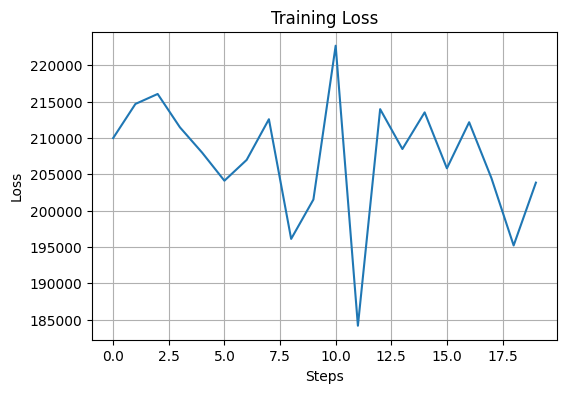

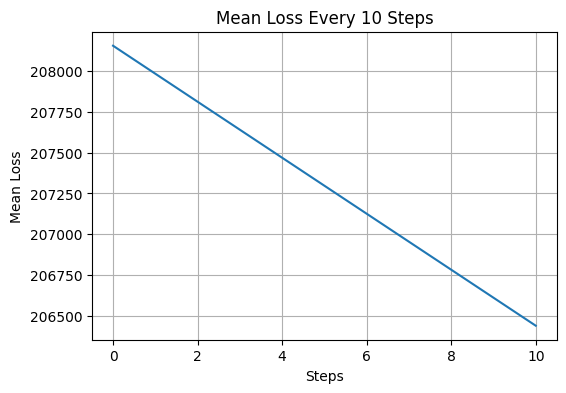

In [11]:
# plot loss
def plot_loss(losses):
    plt.figure(figsize=(6, 4))
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    #plt.yscale("log")
    plt.grid()
    plt.savefig(os.path.join(save_dir, f"loss_plot_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
    plt.show()

# Call the function to plot loss
plot_loss(losses)

# Plot the mean losses
def plot_mean_losses(losses, step_size=10):
    mean_losses = [np.mean(losses[i:i + step_size]) for i in range(0, len(losses), step_size)]

    plt.figure(figsize=(6, 4))
    plt.plot(range(0, len(mean_losses) * step_size, step_size), mean_losses)
    plt.xlabel("Steps")
    plt.ylabel("Mean Loss")
    plt.title(f"Mean Loss Every {step_size} Steps")
    #plt.yscale("log")
    plt.grid()
    plt.savefig(os.path.join(save_dir, f"mean_loss_plot_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
    plt.show()

# Call the function to plot mean losses
plot_mean_losses(losses, step_size=10)

Predicted time spent:
Total test predictions:  20083
Total finite predictions:  20071
Predictions below threshold:  18980
Minimum 0.0 and maximum inf

Predicted counts:
Total test predictions:  20083
Minimum 1.02 and maximum 2.465


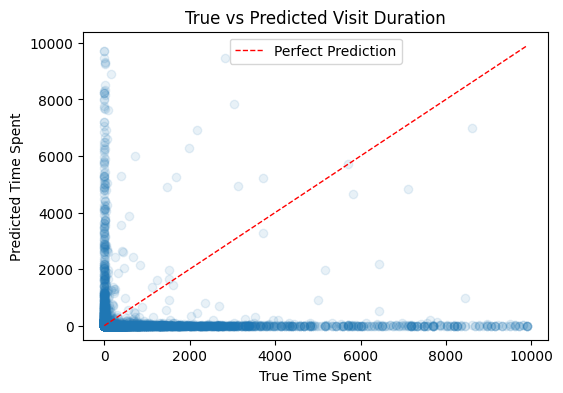

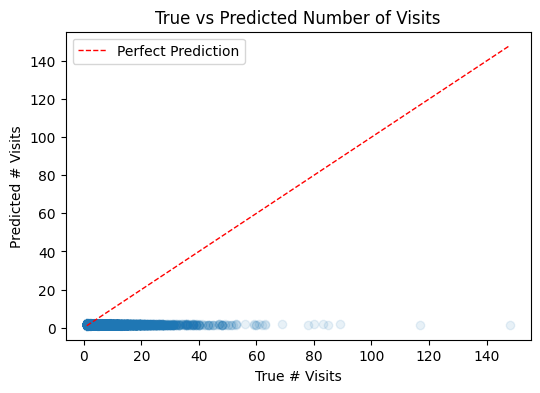

In [12]:
# Plot predictions on test set
x_emb_test = x_emb_test.to(device).to(torch.float64)
d_demo_test = d_demo_test.to(device).to(torch.float64)
v_time_test = v_time_test.to(device).to(torch.float64)
v_time_test_log = v_time_test_log.to(device).to(torch.float64)
c_count_test = c_count_test.to(device).to(torch.float64)

predictive = Predictive(
    MixtureModel,
    guide=MixtureModelGuide,
    num_samples=200,                      # number of posterior draws
    return_sites=["obs_logv", "obs_c"]
)

# Draw posterior‐predictive samples
samples = predictive(x_emb_test_pca, d_demo_test, None, None, G, device)

# Compute the posterior mean prediction for each outcome
pred_v_log = samples["obs_logv"].mean(0)
pred_v_log = reverse_standardize_tensor(pred_v_log, v_time_mean, v_time_std)
pred_v = torch.exp(pred_v_log)
pred_v = pred_v.cpu().numpy()

pred_c = samples["obs_c"].mean(dim=0).cpu().numpy()

# Get the “true” values
v_time_test_log_reversed = reverse_standardize_tensor(v_time_test_log, v_time_mean, v_time_std)
true_v = torch.exp(v_time_test_log_reversed)
true_v   = true_v.cpu().numpy()

true_c = c_count_test.cpu().numpy()

threshold = 1e4

# Create a valid mask
print("Predicted time spent:")
print("Total test predictions: ", len(pred_v))
print("Total finite predictions: ", sum(np.isfinite(pred_v)))
print("Predictions below threshold: ", sum(pred_v < threshold))
print(f"Minimum {pred_v.min()} and maximum {pred_v.max()}")

print("\nPredicted counts:")
print("Total test predictions: ", len(pred_c))
print(f"Minimum {pred_c.min()} and maximum {pred_c.max()}")


mask = np.isfinite(pred_v) & (pred_v < threshold) & (true_v < threshold)
# Apply the mask to the true and predicted values
true_v = true_v[mask]
pred_v = pred_v[mask]

# 6. Plot True vs Predicted for time
if true_v.size == 0 or pred_v.size == 0:
    print("No valid data to plot.")
else:
    plt.figure(figsize=(6, 4))
    plt.scatter(true_v, pred_v,  alpha=0.1)
    plt.plot([true_v.min(), true_v.max()],
            [true_v.min(), true_v.max()],
             'r--', linewidth=1,label="Perfect Prediction")
    plt.xlabel("True Time Spent")
    plt.ylabel("Predicted Time Spent")
    plt.title("True vs Predicted Visit Duration")
    plt.legend()
    plt.savefig(os.path.join(save_dir,f"time_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
    plt.show()

# 7. Plot True vs Predicted for visits
plt.figure(figsize=(6, 4))
plt.scatter(true_c, pred_c, alpha=0.1)
plt.plot([true_c.min(), true_c.max()],
         [true_c.min(), true_c.max()],
          'r--', linewidth=1, label="Perfect Prediction")
plt.xlabel("True # Visits")
plt.ylabel("Predicted # Visits")
plt.title("True vs Predicted Number of Visits")
plt.legend()
plt.savefig(os.path.join(save_dir,f"count_pred_true_{G}groups_{total_samples}samples_{num_steps}steps.pdf"))
plt.show()